# Quantum Channel Detection:

**This code includes implementation and simulations of Sections 2 and 3 from the paper by:**

<p style="text-align: center;"><b>C. Macchiavello and M. Rossi Dipartimento di Fisica and INFN-Sezione di Pavia, Italy</b></p>

* **The method detects properties of quantum channels, assuming that some a priori information about the form of the channel is available**
* **The method is based on a correspondence with entanglement detection methods for multipartite density matrices based on witness operators**


# Importing

In [2]:
# Useful additional packages 
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import os
from copy import deepcopy

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, execute, assemble
from qiskit.tools.visualization import circuit_drawer, plot_bloch_multivector, plot_histogram
import qiskit.quantum_info as qi

In [3]:
from qiskit import IBMQ
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-wits', group='internal', project='stellenbosch-uni')
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

/var/folders/mt/r41fpk8j6fs92x69_9hy27f40000gn/T/ipykernel_84531/3077517601.py:2: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/var/folders/mt/r41fpk8j6fs92x69_9hy27f40000gn/T/ipykernel_84531/3077517601.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


# Functions

In [4]:
"""Calculates expectation value of a witness operator.

Takes as input a Qiskit counts dictionary for a set of physically measured
operators
"""


def compare(pauli_str_wit, pauli_str_exp):
    """Check whether pauli_wit can be derived from pauli_exp.
    i.e. we want to know whether all non-'I' entries of pauli_wit match up
    with pauli_exp
    """
    all_match = True
    for i in range(len(pauli_str_wit)):
        if pauli_str_wit[i] != 'I':
            if pauli_str_wit[i] != pauli_str_exp[i]:
                all_match = False

    return all_match

def expectation_from_counts(op_str, counts):
    """Calculate the expectation value of multi-qubit operator.

    Takes as input a Qiskit counts dict. If the operator contains identities
    the counts dict for a different but matching operator may be substituted.

    e.g. for 'XIXI' the counts dict of 'XYXZ' may be used.
    """
    # For Validation:
    
    # print("op_str:", op_str)
    # print("counts:", counts)
    expectation_val = 0
    for outcome, outcome_count in counts.items():
        eigval = 1
        for i in range(len(op_str)):
            if op_str[i] != 'I':
                eigval *= -1 if outcome[i] == '1' else 1

        expectation_val += eigval * outcome_count

    expectation_val /= total_shots

    return expectation_val


# Define the function to calculate expectation value of W_CNOT

def calculate_expectation_value(basis_wit, bases_exp, binary_counts):
    """Calculate the expectation value of a witness operator.

    Takes as input the witness operator basis, a list of expected operator bases,
    and a Qiskit counts dictionary for a set of physically measured operators.

    Parameters:
    - basis_wit (list of tuples): List of tuples, each containing the sign and Pauli string of a witness operator.
    - bases_exp (list of strings): List of expected operator bases.
    - counts (dict): Qiskit counts dictionary containing the outcomes of quantum measurements.

    Returns:
    - float: The calculated expectation value of the witness operator.
    """
    # For Validation:
    
    # print("basis_wit:", basis_wit)
    # print("bases_exp:", bases_exp)
    # print("binary_counts:", binary_counts)

    expectation_val_wit = 0
    # match_list = []
    for tup in basis_wit:
        sign = tup[0]
        pauli_str_wit = tup[1]

        for pauli_str_exp in bases_exp:
            if compare(pauli_str_wit, pauli_str_exp):
                # match_list.append(pauli_str_wit)
                expectation_val_wit += sign * expectation_from_counts(pauli_str_exp, binary_counts)
                break

    expectation_val_wit /= total_shots
    return expectation_val_wit #,match_list

def str_from_hexa(key):
    """
    Convert a hexadecimal key to its binary representation as a string.

    Args:
        key (str): Hexadecimal key to be converted.

    Returns:
        str: Binary representation of the key as a string.
    """
    # Convert the hexadecimal key to an integer and then to a binary string
    binary_str = str(bin(int(key, 16)))[2:]
    
    # Return the binary representation
    return binary_str.zfill(4)

def rename_keys_to_str(counts_dict):
    """
    Convert hexadecimal keys in a counts dictionary to binary strings.

    Args:
        counts_dict (dict): Dictionary of counts with hexadecimal keys.

    Returns:
        dict: Dictionary of counts with binary string keys.
    """
    binary_counts_dict = {str_from_hexa(key): val for key, val in counts_dict.items()}
    return binary_counts_dict

# # Example usage:
# result = result_manila.result()
# job_index = 0  # Replace with the index of the job result you want to process
# counts_dict = result.results[job_index].data.counts
# binary_counts_dict = dict_str_key(counts_dict)
# print(binary_counts_dict)

# States & Operators Definitions:

In [5]:
XX = qi.Pauli('XX')
YY = qi.Pauli('YY') 
ZZ = qi.Pauli('ZZ')
II = qi.Operator.from_label('II')

# Matrix representations of Pauli operators
XX_matrix = XX.to_matrix()
YY_matrix = YY.to_matrix()
ZZ_matrix = ZZ.to_matrix()
II_matrix = np.eye(4)


# Define the maximally entangled state |α⟩⟨α|
alpha = np.array([0, 1, -1, 0]) / np.sqrt(2)
alpha_density_matrix = np.outer(alpha, alpha.conj())
print(alpha_density_matrix)


# Bell's Density matrices:

v00 = qi.Statevector.from_label('00')
v01 = qi.Statevector.from_label('01')
v10 = qi.Statevector.from_label('10')
v11 = qi.Statevector.from_label('11')

PhiPlus = qi.DensityMatrix(1/np.sqrt(2)*(v00+v11))
PhiMinus = qi.DensityMatrix(1/np.sqrt(2)*(v00-v11))
PsiPlus = qi.DensityMatrix(1/np.sqrt(2)*(v01+v10))
PsiMinus = qi.DensityMatrix(1/np.sqrt(2)*(v01-v10))

# Bell_state_list = [PhiPlus, PhiMinus, PsiPlus, PsiMinus]


[[ 0.   0.  -0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [-0.  -0.5  0.5 -0. ]
 [ 0.   0.  -0.   0. ]]


# Section 2: Detection of Entanglement Breaking in the Depolarising Channel Using Witness Operator:
* **Warner State is the corresponding set of Choi bipartite density operators**

In [6]:
#  Numpy:
# Create the Werner density matrix ρₚ
werner_density_matrix_lambda = lambda p: (1 - 4/3 * p) * alpha_density_matrix + (p/3) * II_matrix

# Create the Witness Operator
Witness_EB_matrix = 0.5 * (II_matrix + XX_matrix + YY_matrix + ZZ_matrix)

# Same with Qskit:
werner_density_matrix_lambda_qiskit = lambda p: (1 - 4/3 * p) * PsiMinus + (p/3) * II       # No sure which Bell state
Witness_EB = 0.5 * (II + XX + YY + ZZ)                                              # Signs !

# Tests:
print("Trace in Numpy is:", np.trace(werner_density_matrix_lambda(0)))
print("Trace in Qiskit is:", werner_density_matrix_lambda_qiskit(0).trace())
print()
print("Type in Numpy is:", type(werner_density_matrix_lambda(0)))
print("Type in Qiskit is:", type(werner_density_matrix_lambda_qiskit(0)))
print()
print("Werner state Numpy:")
print()
print(werner_density_matrix_lambda(0))
print()
print("Werner state Qiskit:")
print()
print(werner_density_matrix_lambda_qiskit(0))

Trace in Numpy is: 0.9999999999999998
Trace in Qiskit is: (0.9999999999999998+0j)

Type in Numpy is: <class 'numpy.ndarray'>
Type in Qiskit is: <class 'qiskit.quantum_info.states.densitymatrix.DensityMatrix'>

Werner state Numpy:

[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

Werner state Qiskit:

DensityMatrix([[ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
               [ 0. +0.j,  0.5+0.j, -0.5+0.j,  0. +0.j],
               [ 0. +0.j, -0.5+0.j,  0.5+0.j,  0. +0.j],
               [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j]],
              dims=(2, 2))


# Applying & Ploting 
* Applying $W_{EB}$ on $\rho_p$, the Werner density matrix, fro diffrent values of $p\in [0,1]$, and ploting
* The process is done in both Qiskit and Numpy (for practice and debugging)

In [7]:
# Parameters
p_list = list(np.linspace(0, 1, 100))
trace_list = []
trace_list_qiskit = []

for val in p_list:
    witness_werner = Witness_EB_matrix @ werner_density_matrix_lambda(val)
    # print(witness_werner)
    # witness_werner = qi.DensityMatrix(werner_density_matrix_lambda(val)).evolve(qi.Operator(Witness_EB_matrix))
    Tr_witness_werner = np.trace(witness_werner)
    trace_list.append(Tr_witness_werner)
    
    witness_werner_qiskit = Witness_EB @ werner_density_matrix_lambda_qiskit(val).to_operator()
    # witness_werner_qiskit = Witness_EB.data @ werner_density_matrix_lambda_qiskit(val).data # Also an option
    
    Tr_qiskit = np.trace(witness_werner_qiskit)
    # Tr_qiskit = witness_werner_qiskit.trace() # rasies an error 
    trace_list_qiskit.append(Tr_qiskit)
    
# Plot the results

# plt.plot(p_list, trace_list, label='By Numpy')

# plt.plot(p_list, trace_list_qiskit, label='By Qiskit')

# plt.xlabel('p')
# plt.ylabel(r'$\mu_c$')
# plt.title(r'Tr [$Witness_{EB} \cdot C_{M}}$ vs p$\in [0,1]$')
# plt.grid()
# # plt.legend()
# plt.show()


# Section 3: Detection Separability of (Random) Unitary

<!-- # Not Necessarily Useful... (Focused on Sec.III at the Moment)
**Witness Operators for general PPT Channels - steps:** 

* We want to detect entanglement in NPT/PPT map; $\mathcal{M}$
* We difiene the witness operator:
* $$W_{PPT}= \ket{\lambda_{-}} \bra{\lambda_{-}}^\mathcal{T_A}$$
* $\ket{\lambda_{-}}$ is most negative value of the NPT (or PPT, right?) map $\mathcal{M}$
* For the general case I will probably implement $W_{PPT}$ by Eq.(40) from the main paper


* **Reading on Witness in general**
* **Ref.(7) (idea)**
* **Sec.V** -->

Circuit In Basic Form Before Measurement Composition and Execution:


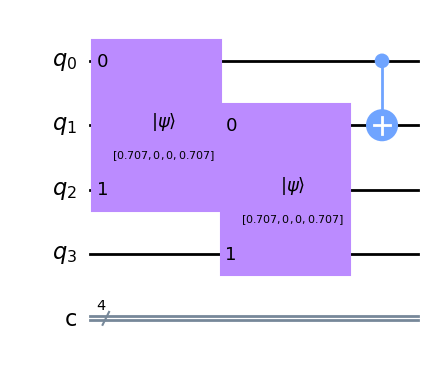

In [8]:
# Bell's Density matrices:
# v00, v01, v10, v11, PhiPlus, PhiMinus, PsiPlus, PsiMinus are defined here

# Step 1: Create the quantum circuit
qc = QuantumCircuit(4, 4)

# Choose Bell states for qubits AC and BD
rho_AC = PhiPlus  # Choose the desired Bell state for qubits AC
rho_BD = PhiPlus  # Choose the desired Bell state for qubits BD

# Extract amplitudes from the density matrices
amplitudes_AC = np.sqrt(np.diag(rho_AC.data))
amplitudes_BD = np.sqrt(np.diag(rho_BD.data))

# Apply initialization to qubits AC and BD
qc.initialize(amplitudes_AC, [0, 2])
qc.initialize(amplitudes_BD, [1, 3])

# Apply CNOT gate on qubits A and B
qc.cx(0, 1)

# Visualize the circuit without measurements
print('Circuit In Basic Form Before Measurement Composition and Execution:')
qc.draw('mpl')



$W_{CNOT}=$
$\frac{1}{64}[31*1111−1X1X−XXX1−X1XX−ZZ1Z+ZY1Y +YYXZ+YZXY−Z1Z1−ZXZX+YXY 1+Y1YX−1ZZZ+1YZY +XYYZ+XZYY]$

By the paper, the expectation values of operators: [$1X1X$ , $XXX1$ , $X1XX$]

can be obtained by measuring the operator XXXX and suitably processing the experimental data.

Similar groupings can be done for the other terms in $W_{CNOT}$

In [9]:
# Define the measurement bases

bases_exp = ['XXXX', 'ZZZZ', 'ZYZY', 'YXYX', 'YYXZ', 'YZXY', 'ZXZX', 'XYYZ', 'ZXYY']

bases_wit = [(31, 'IIII'),(-1, 'IXIX'),(-1, 'XXXI'),(-1, 'XIIX'),
             (-1, 'ZZIZ'),(+1, 'ZYIY'),(+1, 'YYXZ'),(+1, 'YZXY'),
             (-1, 'ZIZI'),(-1, 'ZXZX'),(+1, 'YXYI'),(+1, 'YIYX'),
             (-1, 'IZZZ'),(+1, 'IYZY'),(+1, 'XYYZ'),(+1, 'XZYY')]

**Use Aer's qasm_simulator Or Real Quantum Device:**

In [10]:
# backend_sim = Aer.get_backend('qasm_simulator') # Simulator
backend_manila = provider.get_backend('ibmq_manila') # Real Machine

circ_list = []
composed_circuit_list =[]

# Loop over each basis_exp
expectation_values = []
for basis in bases_exp:
    temp_qc = deepcopy(qc)

    # Apply gates for the specified basis_wit
    for i, gate in enumerate(basis):  # Use basis to access the Pauli string
    
        if gate == 'X':
            temp_qc.h(i)
        elif gate == 'Y':
            temp_qc.sdg(i)
            temp_qc.h(i)
    # print(temp_qc) Validation

    # Measure the circuit
    temp_qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
    composed_circuit_list.append(temp_qc)
    temp_qc = transpile(temp_qc, backend_manila)
    circ_list.append(temp_qc)


job_length = len(circ_list)
print('Job length is: ',job_length)  

Job length is:  9


# **Plot Before Execute !**
**UnComment of Circuit Was Changed**

In [11]:
# # Get the current working directory
# current_directory = os.getcwd()

# # Create the 'CircuitPlots' directory if it doesn't exist
# if not os.path.exists('CircuitPlots'):
#     os.makedirs('CircuitPlots')

# # Create the 'TranspiledCircuitPlots' directory if it doesn't exist
# if not os.path.exists('TranspiledCircuitPlots'):
#     os.makedirs('TranspiledCircuitPlots')

# # Iterate through the list of quantum circuits and save each plot
# for i, circuit in enumerate(composed_circuit_list):
#     filename = f'CircuitPlots/Sec3_plot{i + 1}.png'
#     print(f"Saving circuit {i + 1} as {filename}")
#     circuit_drawer(circuit, output='mpl', filename=filename)
#     plt.close()  # Close the plot to prevent overlapping
    
# # Same after Transpile

# for i, circuit in enumerate(circ_list):
#     filename = f'TranspiledCircuitPlots/Sec3_plot{i + 1}.png'
#     print(f"Saving circuit {i + 1} as {filename}")
#     circuit_drawer(circuit, output='mpl', filename=filename)
#     plt.close()  # Close the plot to prevent overlapping

    


# **Execute On Real QM !**

In [12]:
total_shots = 16384 # Optional to Change 

**UnComment To Run on Real Machine!:**

In [13]:
# Execute the circuit on ibmq_manila!

# # job_sim = backend_sim.run(transpile(temp_qc, backend_sim), shots=total_shots) # Simulator

# job_manila = backend_manila.run(circ_list,job_name='Nadav', shots=total_shots) # Real Machine

**Wait For Execution On QM Before Retrieving Job**
* Adjustment of: **job_id** might be required 
* After Retrieving once could be commented until Restarting Kernel

In [35]:
# Grab the results from the job:

 ## result_sim = job_sim.result() # Simulator

# Change per each execution on IBMQ Machine:

# Jobs with: total_shots = 2048
job_id1 = 'cjedngbqmesr7lhj5a3g' # Bug1: Had none Optimality Bug (16 measurements instead of 9), Still Valid! 
job_id2 = 'cjf2ecklik6102p271sg' # Bug1: fixed

job_id3 = 'cjfs4fv6dei06650v15g' # Cant remember 

job_id4 = 'cjfs53ocs414jvh5tiu0' # total_shots = 16384
job_id5 = 'cjhnm9q67vbih39cu6lg' # total_shots = 16384
job_id6 = 'cjho3sriept3ght6s4s0' # total_shots = 16384
job_id7 = 'cjho49riept3ght6sdp0' # total_shots = 16384
# Not processed yet
job_id8 = 'cji7j6cul2rlcpo6neng' # total_shots = 16384
job_id9 = 'cji7j727fkv7bhtjo66g' # total_shots = 16384
job_id10 = 'cji7j7sul2rlcpo6nfcg' # total_shots = 16384
job_id11 = 'cji7j8rsogidtk7aodqg' # total_shots = 16384
job_id12 = 'cji7j9j3smr2evnde6lg' # total_shots = 16384
job_id13 = 'cji7jacul2rlcpo6ngkg' # total_shots = 16384
job_id14 = 'cji7jbkul2rlcpo6nh60' # total_shots = 16384
job_id15 = 'cji7jci7fkv7bhtjo9d0' # total_shots = 16384

total_shots = 16384 # Adapt for Analysis

# Retrieve Job From Real Machine (do it once...):
result_manila = backend_manila.retrieve_job(job_id15) # Choose desired job to retrieve 

# For Validation:
# print(type(result_manila.result()))
# print(result_manila.result())

# **Final Processing:**

**Change total_shots !**

In [36]:
# Calculate the expectation value for each basis_wit
expectation_values = []
total_expectation_value = 0  # Initialize the total expectation value

dict_list_hex = [result_manila.result().results[i].data.counts for i in range(job_length)] # Extract counts data from job's results 
dict_list_binary = [] 

for hex_dict in dict_list_hex:  # Iterate over the list of dictionaries containing experimental results
    binary_counts_dict = rename_keys_to_str(hex_dict)  # Convert keys to binary strings
    dict_list_binary.append(binary_counts_dict)
i=0
# print(dict_list_binary)
for binary_counts_dict in dict_list_binary:
    expectation_val = calculate_expectation_value(bases_wit, bases_exp, binary_counts_dict)
    expectation_values.append(expectation_val)
    total_expectation_value += expectation_val

    # Plot histogram using matplotlib
    # plt.figure(figsize=(8, 6))
    # plt.bar(binary_counts_dict.keys(), binary_counts_dict.values())
    # plt.xlabel('Measurement')
    # plt.ylabel('Counts')
    # plt.title(r'Bar Plot of $' + str(bases_exp[i]) + '$')
    # plt.show()
    # plt.pause(0.5)  # Add a delay to observe the histogram before proceeding
    i+=1
    
# Calculate and print the total expectation value
print("Total Expectation Value:", total_expectation_value)


Total Expectation Value: -0.0024644285440444946


# Results and Statistics

**Collecting results after processing:**

In [39]:
res_job4 = -0.0027367398142814636
res_job5 = -0.0027540624141693115
res_job6 = -0.0027785450220108032
res_job7 = -0.0027027875185012817
res_job8 = -0.002727039158344269
res_job9 = -0.0026736855506896973
res_job10 = -0.0026531293988227844
res_job11 = -0.0026531293988227844
res_job12 = -0.002743033692240715
res_job13 = -0.002705790102481842
res_job14 = -0.0026261061429977417
res_job15 = -0.0024644285440444946



res_array = np.array([-0.0027367398142814636
                      , -0.0027540624141693115
                      , -0.0027785450220108032
                      , -0.0027027875185012817
                      , -0.002727039158344269
                      , -0.0026736855506896973
                      , -0.0026531293988227844
                      , -0.0026531293988227844
                      , -0.002743033692240715
                      , -0.002705790102481842
                      , -0.0026261061429977417
                      , -0.0024644285440444946])
res_std = res_array.std()
res_mean = res_array.mean()
print("Mean of expectation values", res_mean)
print("Standard deviation of expectation values", res_std)

Mean of expectation values -0.0026848730631172657
Standard deviation of expectation values 7.977085330393561e-05


**Perform statistical test hipotesis:**

In [40]:
from scipy import stats

# Sample data (replace with your actual data)
res_array = np.array([-0.0027367398142814636, -0.0027540624141693115,
                      -0.0027785450220108032, -0.0027027875185012817])

# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(res_array, popmean=0)

# Significance level
alpha = 0.01

# Check if the p-value is less than the significance level
if p_value < alpha:
    print("Reject null hypothesis: The mean is significantly less than zero.")
    if res_array.mean() <= 0:
        print("Non-SRU")
    else:
        print("SRU")
else:
    print("Fail to reject null hypothesis: The mean is not significantly less than zero.")
    if res_array.mean() <= 0:
        print("SRU")
    else:
        print("Non-SRU")

Reject null hypothesis: The mean is significantly less than zero.
Non-SRU


# Dumb Stuff 

In [41]:
# from nbformat import read

# # Load the Jupyter notebook file
# with open('QC_Detection_IBMQ.ipynb', 'r') as nb_file:
#     nb = read(nb_file, as_version=4)

# # Count the total number of lines in code cells
# total_lines = sum(len(cell['source'].split('\n')) for cell in nb.cells if cell.cell_type == 'code')

# print("Total lines of code:", total_lines)

Total lines of code: 445
